# Predicting ICU Mortality: Preliminary Analysis

## Project Overview

This project aims to predict in-hospital mortality for ICU patients using a public, time-series dataset from the PhysioNet 2012 Challenge, available on Kaggle. The dataset contains records for 4,000 ICU stays, including static demographic data and dynamic, time-stamped physiological measurements.

The goal of this initial notebook is to perform the necessary data loading, preprocessing, and exploratory data analysis (EDA) to establish a baseline understanding of the data and identify key challenges and features. The findings will inform the subsequent feature engineering and modeling phases.

---

## Proposed High-Level Plan

- **Feature Engineering:** Extract meaningful features from the time-series data (e.g., summary statistics, trends over time).

- **Modeling:** Build and compare several classification models (e.g., Logistic Regression, XGBoost) to predict the `In-hospital_death` outcome.

- **Address Challenges:** Implement strategies to handle significant class imbalance and missing data.

- **Interpretation:** Use SHAP (SHapley Additive exPlanations) to interpret the model's predictions and understand which features are the most influential.

- **Dashboard (Stretch Goal):** Create a simple interactive dashboard to visualize model predictions.


## Setup and Configuration

This cell imports the necessary libraries for data manipulation (pandas, numpy), plotting (matplotlib, seaborn), and progress tracking (tqdm). It also defines the file paths and the specific parameters we intend to extract from the patient records.

In [18]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

# --- Configuration ---
BASE_PATH = './data'
SET_A_PATH = os.path.join(BASE_PATH, 'set-a', 'set-a') 
OUTCOMES_FILE = os.path.join(BASE_PATH, 'Outcomes-a.txt')

# Time-series parameters to aggregate
TIMESERIES_PARAMS = [
    'HR', 'NIDiasABP', 'NIMAP', 'NISysABP', 'RespRate',
    'SpO2', 'Temp', 'Glucose', 'pH'
]

# Static parameters to extract directly
STATIC_PARAMS = ['Age', 'Gender', 'Height', 'ICUType', 'Weight']

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')

## Data Loading and Preprocessing

The dataset is structured with one file per patient, containing multiple time-stamped measurements. To prepare this for a machine learning model, we must transform this time-series data into a static, one-row-per-patient format.

The function below, `process_patient_file`, handles this transformation. For each patient, it:

- Extracts the static demographic data (e.g., `Age`, `Gender`).
- For each time-series parameter (e.g., `Heart Rate`), it calculates a set of summary statistics (`mean`, `std`, `min`, `max`) that represent the patient's measurements over their entire stay.
- Combines these features into a single dictionary, which will become one row in our final DataFrame.

The subsequent code cell iterates through all 4,000 patient records, applies this function, and assembles the results into a single `features_df` DataFrame.


In [9]:
def load_outcomes(file_path):
    """Loads the outcomes data, which maps RecordID to mortality."""
    try:
        return pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"Error: Outcomes file not found at {file_path}")
        return None

def process_patient_file(record_id, data_path):
    """
    Reads a patient's .txt file and extracts both static and aggregated time-series features.
    """
    file_path = os.path.join(data_path, f"{record_id}.txt")
    try:
        patient_df = pd.read_csv(file_path)
        patient_df.rename(columns={'Parameter': 'parameter', 'Value': 'value'}, inplace=True)
        
        # --- Extract Static Features ---
        static_features = {'RecordID': record_id}
        for param in STATIC_PARAMS:
            # Static values are usually at the top, take the first one found
            value = patient_df[patient_df['parameter'] == param]['value'].iloc[0]
            static_features[param] = value if value != -1 else np.nan # Replace -1 with NaN

        # --- Aggregate Time-Series Features ---
        ts_features = {}
        for param in TIMESERIES_PARAMS:
            param_data = patient_df[patient_df['parameter'] == param]['value']
            if not param_data.empty:
                ts_features[f'{param}_mean'] = param_data.mean()
                ts_features[f'{param}_std'] = param_data.std()
                ts_features[f'{param}_min'] = param_data.min()
                ts_features[f'{param}_max'] = param_data.max()
                ts_features[f'{param}_count'] = param_data.count()
            else:
                # Fill with NaN if no measurements exist
                for stat in ['mean', 'std', 'min', 'max', 'count']:
                    ts_features[f'{param}_{stat}'] = np.nan if stat != 'count' else 0
        
        # Combine both dictionaries of features
        static_features.update(ts_features)
        return static_features
        
    except (FileNotFoundError, IndexError):
        # Return None if file is not found or is empty/malformed
        return None

## Final Data Assembly

Here, we merge the `features_df` (containing our engineered features) with the `outcomes_df` (containing the mortality labels). This creates the final, analysis-ready DataFrame where each row corresponds to a unique patient and their associated features and outcome.


In [13]:
outcomes_df = load_outcomes(OUTCOMES_FILE)

if outcomes_df is not None:
    record_ids = outcomes_df['RecordID'].tolist()
    
    all_features = []
    missing_files_count = 0
    
    # Use tqdm to create a progress bar
    for record_id in tqdm(record_ids, desc="Processing patient files"):
        patient_features = process_patient_file(record_id, SET_A_PATH)
        
        if patient_features:
            all_features.append(patient_features)
        else:
            missing_files_count += 1
    
    features_df = pd.DataFrame(all_features)
    
    if missing_files_count > 0:
        print(f"\nWarning: Skipped {missing_files_count} records because their data files were not found or were malformed.")
    
    print(f"Created features DataFrame. Shape: {features_df.shape}")
    features_df.head()


Processing patient files:   0%|          | 0/4000 [00:00<?, ?it/s]

Created features DataFrame. Shape: (4000, 51)


In [14]:
final_df = pd.merge(features_df, outcomes_df, on='RecordID', how='left')
final_df.set_index('RecordID', inplace=True)

print("Final merged DataFrame shape:", final_df.shape)
final_df.head()

Final merged DataFrame shape: (4000, 55)


,Age,Gender,Height,ICUType,Weight,HR_mean,HR_std,HR_min,HR_max,HR_count,...,pH_mean,pH_std,pH_min,pH_max,pH_count,SAPS-I,SOFA,Length_of_stay,Survival,In-hospital_death
RecordID,,,,,,,,,,,,,,,,,,,,,
132539,54.0,0.0,NaN,4.0,NaN,70.810811,8.605030,58.0,86.0,37,...,NaN,NaN,NaN,NaN,0,6,1,5,-1,0
132540,76.0,1.0,175.3,2.0,76.0,80.794118,6.739411,65.0,90.0,68,...,7.395,0.037796,7.34,7.45,8,16,8,8,-1,0
132541,44.0,0.0,NaN,3.0,56.7,83.759259,11.536546,57.0,113.0,54,...,7.495,0.017321,7.47,7.51,4,21,11,19,-1,0
132543,68.0,1.0,180.3,3.0,84.6,70.983333,7.738286,57.0,88.0,60,...,NaN,NaN,NaN,NaN,0,7,1,9,575,0
132545,88.0,0.0,NaN,3.0,NaN,74.958333,7.454710,65.0,94.0,48,...,NaN,NaN,NaN,NaN,0,17,2,4,918,0


## Exploratory Data Analysis (EDA)

### Finding 1: Missing Data

Real-world medical data is often incomplete. We check for the percentage of missing values in each feature column.

**Key Insight:** Some features like `pH` and `RespRate` have a high percentage of missing data, which will require an imputation strategy. Other potential features, like `SpO2`, were not present in the files at all and have been excluded. Core vitals like `HR` and `Temp` are mostly complete.


In [15]:
missing_percentage = final_df.isnull().sum() * 100 / len(final_df)
missing_percentage[missing_percentage > 0].sort_values(ascending=False)

SpO2_max          100.000
SpO2_min          100.000
SpO2_std          100.000
SpO2_mean         100.000
RespRate_std       72.500
RespRate_mean      72.475
RespRate_max       72.475
RespRate_min       72.475
Height             47.350
pH_std             31.975
pH_min             24.000
pH_mean            24.000
pH_max             24.000
NIMAP_std          16.300
NIDiasABP_std      16.200
NISysABP_std       16.125
NIMAP_min          12.975
NIMAP_max          12.975
NIMAP_mean         12.975
NIDiasABP_max      12.925
NIDiasABP_min      12.925
NIDiasABP_mean     12.925
NISysABP_max       12.675
NISysABP_min       12.675
NISysABP_mean      12.675
Weight              8.150
Glucose_std         8.075
Glucose_mean        2.825
Glucose_min         2.825
Glucose_max         2.825
Temp_std            1.625
Temp_mean           1.600
Temp_min            1.600
Temp_max            1.600
HR_std              1.600
HR_mean             1.575
HR_min              1.575
HR_max              1.575
Gender      

### Finding 2: Outcome Distribution (Class Imbalance)

Next, we analyze the distribution of our target variable, `In-hospital_death`.

**Key Insight:** The dataset is highly imbalanced. Approximately 86% of patients survived, while only 14% died. This is a critical finding, as a naive model could achieve high accuracy by simply always predicting "survived." Our modeling strategy must account for this imbalance using techniques like SMOTE or class weights.


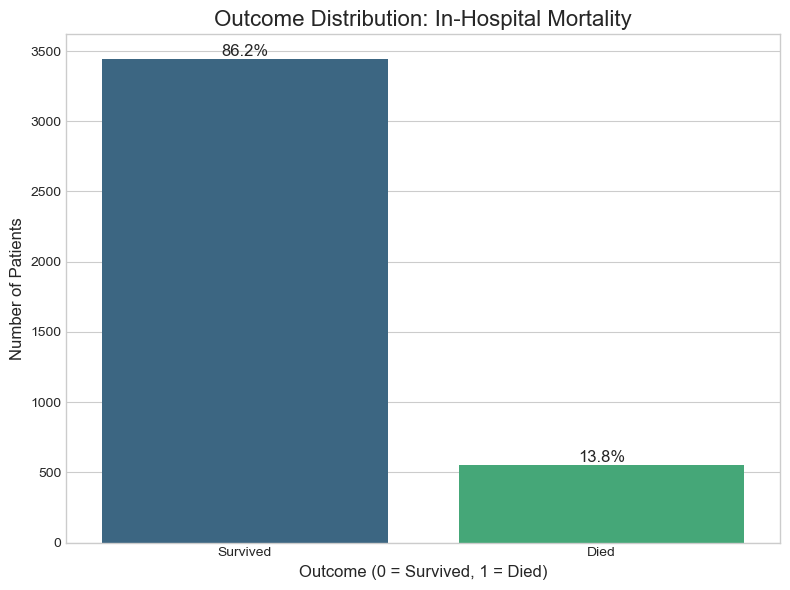

0    3446
1     554
Name: In-hospital_death, dtype: int64


In [16]:
fig, ax = plt.subplots(figsize=(8, 6))
mortality_counts = final_df['In-hospital_death'].value_counts()
sns.barplot(x=mortality_counts.index, y=mortality_counts.values, ax=ax, palette='viridis')

ax.set_title('Outcome Distribution: In-Hospital Mortality', fontsize=16)
ax.set_ylabel('Number of Patients', fontsize=12)
ax.set_xlabel('Outcome (0 = Survived, 1 = Died)', fontsize=12)
ax.set_xticklabels(['Survived', 'Died'])

# Add percentage labels
total = len(final_df)
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()

print(mortality_counts)

### Finding 3: Feature Distributions by Outcome

Finally, we visualize how the distributions of key features differ between patients who survived and those who did not. This gives us an early indication of which features are likely to be predictive.

**Key Insight:** There are clear visual differences for several features:

- **Age:** The distribution for patients who died is visibly shifted towards higher ages.
- **Blood Pressure (NISysABP):** Patients who died tend to have a lower average systolic blood pressure.
- **pH:** Abnormal blood pH is strongly associated with mortality.
- **Temperature:** Average temperature shows less separation between the two groups.

These insights confirm that we have strong predictive signals in the data, making this a promising project.


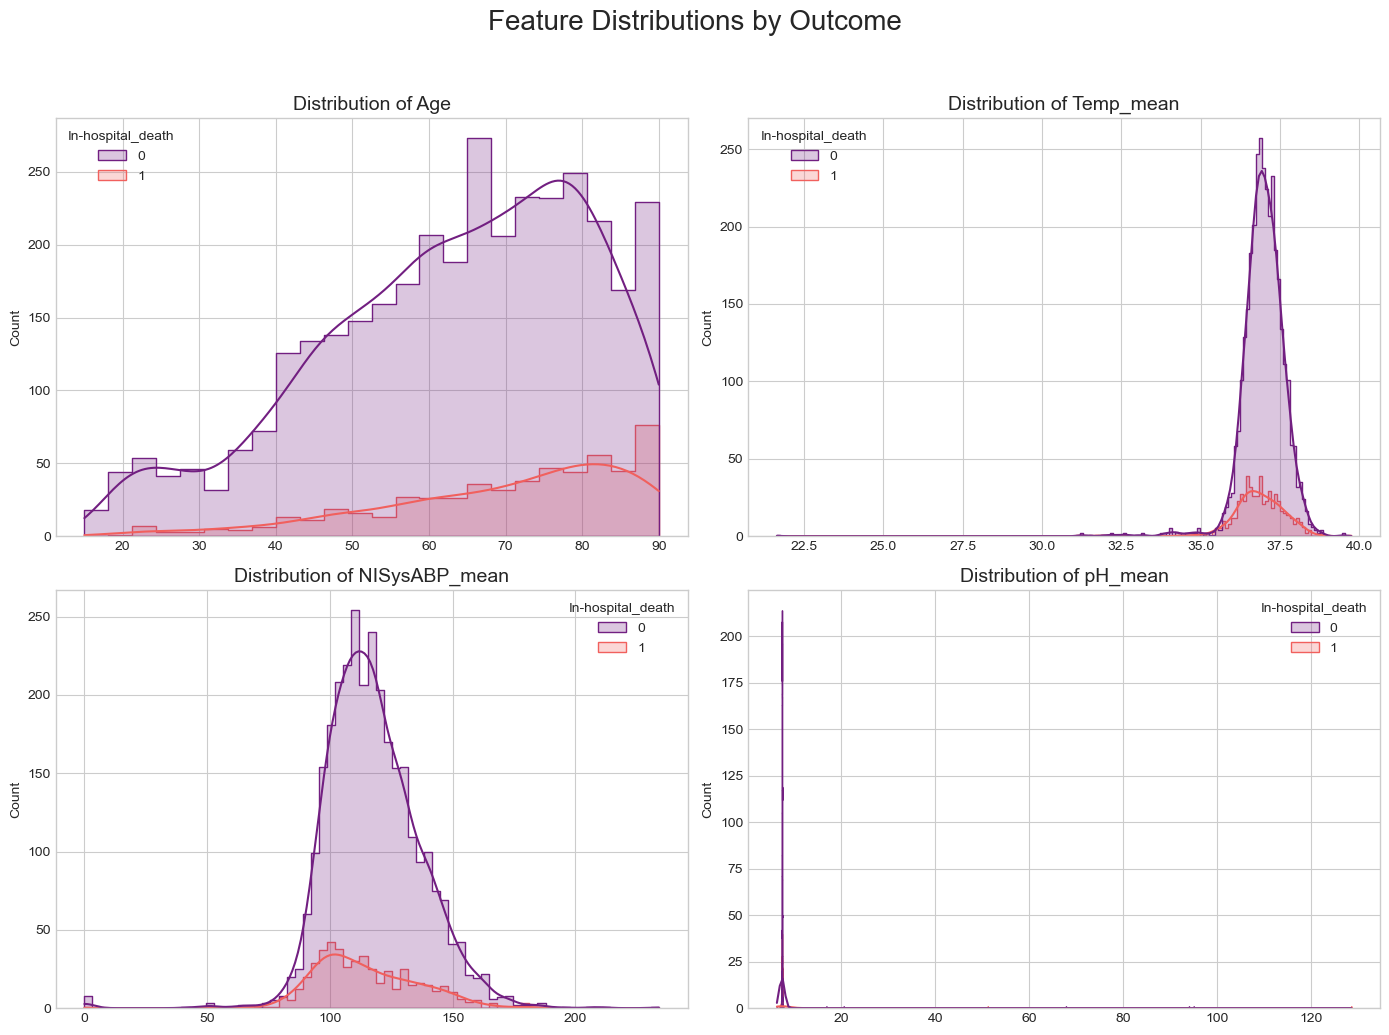

In [17]:
features_to_plot = ['Age', 'Temp_mean', 'NISysABP_mean', 'pH_mean']

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, feature in enumerate(features_to_plot):
    if feature in final_df.columns:
        sns.histplot(data=final_df, x=feature, hue='In-hospital_death', 
                     kde=True, ax=axes[i], palette='magma', element="step")
        axes[i].set_title(f'Distribution of {feature}', fontsize=14)
        axes[i].set_xlabel('')
        axes[i].set_ylabel('Count')

fig.suptitle('Feature Distributions by Outcome', fontsize=20, y=1.03)
plt.tight_layout()
plt.show()